# Spatial indices: Land use mix

This notebook exemplifies the calculation of spatial land use mix indices, as shown in:
* [A framework for evaluating urban land use mix from crowd-sourcing data](https://hal.inria.fr/hal-01396792)

___"Mixed-use development is a type of urban development that blends residential, commercial, cultural, institutional, or entertainment uses, where those functions are physically and functionally integrated, and that provides pedestrian connections"___ [Wikipedia](https://en.wikipedia.org/wiki/Mixed-use_development)

In [1]:
# snippet for relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
import urbansprawl as us

ox.config(log_file=True, log_console=True, log_name='spatial_indices-landusemix', log_filename='spatial_indices-landusemix', use_cache=True)
figsize = (8,8)

### Retrieve data
* Lyon, France

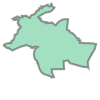

In [2]:
# Get shape for city
city_poly = ox.gdf_from_place("Lyon, France", which_result=1)
# Polygon
city_shape = city_poly.geometry[0]
city_shape

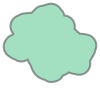

In [3]:
# Dilate the shape of the city to capture a bigger area
city_shape = city_shape.buffer(0.02)
west, south, east, north = city_shape.bounds
city_shape

CPU times: user 56min 51s, sys: 52.8 s, total: 57min 43s
Wall time: 57min 57s


(635392.881135122, 650099.7592789468, 5059979.098570935, 5077557.657349832)

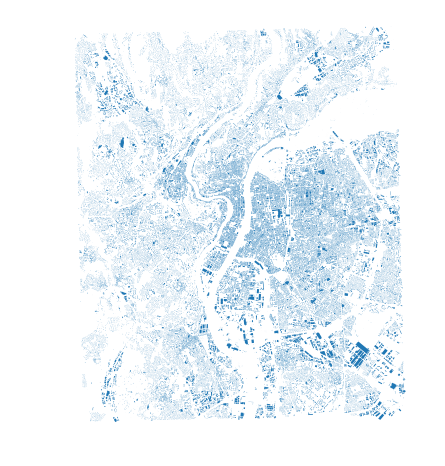

In [4]:
# Retrieve OSM data : Lyon - Bounding box
city_ref = "Lyon_France"
region_args = {"north" : north, "west" : west, "south" : south, "east" : east}
%time df_osm_buildings, df_osm_building_parts, df_osm_pois = us.get_processed_osm_data(city_ref=city_ref, region_args=region_args)
# Plot
ax = df_osm_buildings.plot(figsize=figsize)
ax.axis('off')

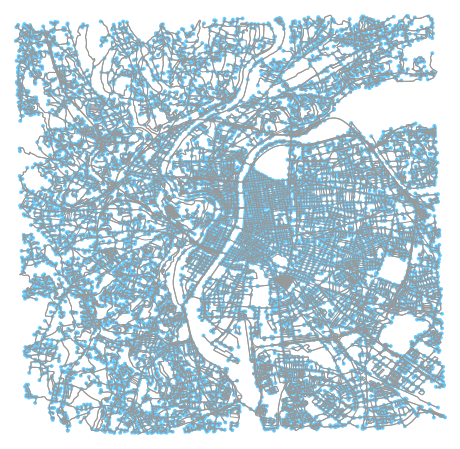

In [5]:
osm_street_network = us.get_route_graph(city_ref)
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0])
f.tight_layout()

### Data visualization
* Buildings and their classified land use
    * Red: Activity uses
    * Blue: Residential uses
    * Green: Mixed-uses

(635817.4641914798, 649633.5892556852, 5060560.4116269825, 5077044.1303451555)

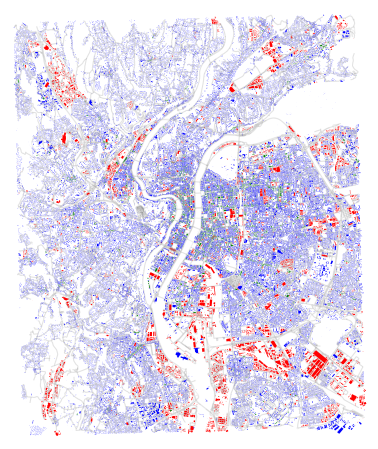

In [6]:
# Get buildings per classification
df_residential = df_osm_buildings[ df_osm_buildings.classification.isin(["residential"]) ]
df_activities = df_osm_buildings[ df_osm_buildings.classification.isin(["activity"]) ]
df_mixed = df_osm_buildings[ df_osm_buildings.classification.isin(["mixed"]) ]

# Plot
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], edge_alpha=0.15, node_alpha=0, show=False, close=False)
# Buildings
if (not df_residential.empty):
    df_residential.plot(figsize=figsize, color="blue", ax=ax)
if (not df_activities.empty):
    df_activities.plot(figsize=figsize, color="red", ax=ax)
if (not df_mixed.empty):
    df_mixed.plot(figsize=figsize, color="green", ax=ax)
ax.axis('off')

### Spatial indices
* Indices are calculated on a regular grid
* For more details on the granularity of analysis, refer to the notebook [4-Spatial-indices-Granularity](https://github.com/lgervasoni/urbansprawl/tree/master/examples/4-Spatial-indices-Granularity.ipynb)

In [7]:
# Create a regular point-grid with step of 100 meters
step = 100
df_indices = us.get_indices_grid(df_osm_buildings, df_osm_building_parts, df_osm_pois, step=step)

### Land use mix indices
* Associated to *walkable distances*
* Degree of co-occurence of activity and residential uses

In [8]:
landusemix_args = {'walkable_distance': 600, 'compute_activity_types_kde': True, 'weighted_kde': True, 
                   'pois_weight': 9, 'log_weighted': True}
%time us.compute_grid_landusemix(df_indices, df_osm_buildings, df_osm_pois, landusemix_args)

CPU times: user 1min 29s, sys: 30.7 s, total: 2min
Wall time: 2min


### Estimation of land use densities
* A probability density function is estimated for each land use (i.e. activity and residential) using Kernel Density Estimation

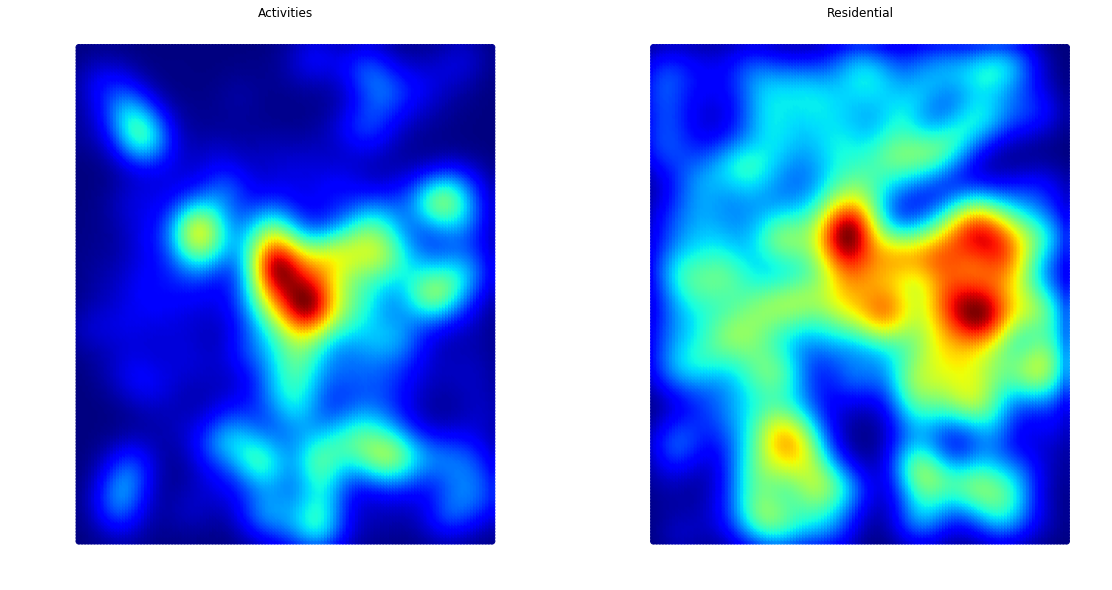

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]) )
# Title
axs[0].set_title("Activities"); axs[1].set_title("Residential")
axs[0].axis('off'); axs[1].axis('off')
# Plots
df_indices.plot("activity_pdf", cmap='jet', ax=axs[0])
df_indices.plot("residential_pdf", cmap='jet', ax=axs[1])
fig.tight_layout(pad=0)

### Activity land uses are further classified
* Commercial and industrial use
* Shops
* Leisure and amenities

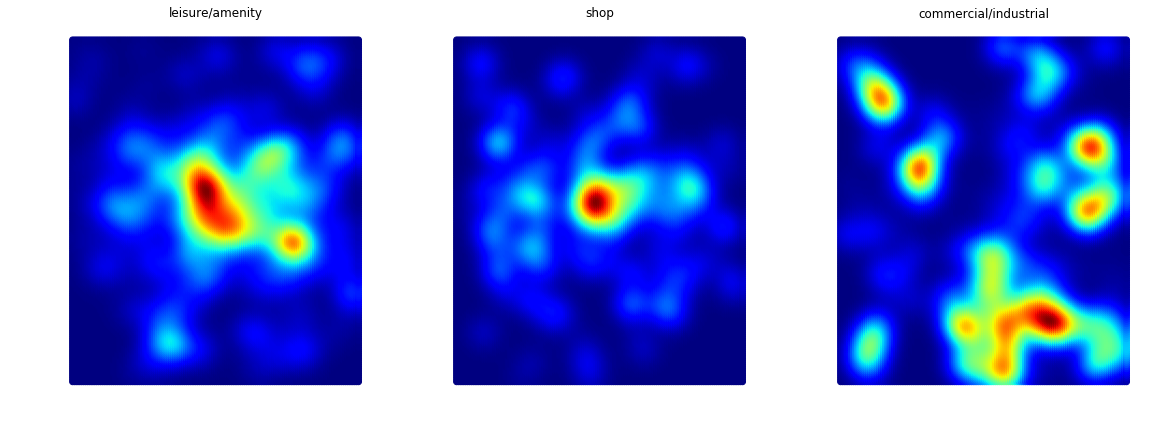

In [10]:
activity_types = us.osm.classification.activity_classification
fig, axs = plt.subplots(1, len(activity_types), figsize=(figsize[0] * 2, figsize[1]) )
for activity, ax_ in zip( activity_types, axs ):
    if (activity+"_pdf" in df_indices.columns):
        df_indices.plot(activity+"_pdf",cmap='jet', legend=False, ax=ax_)
        ax_.axis('off')
        ax_.set_title(activity)
fig.tight_layout(pad=0)

### Spatial land use mix indices
* Land use mix (color): Degree of co-occurence of differing land uses within *walkable* distances
* Land use intensity (bubbles): Denotes local intensity. The higher the intensity, the higher the desire of acquiring good uses mixture

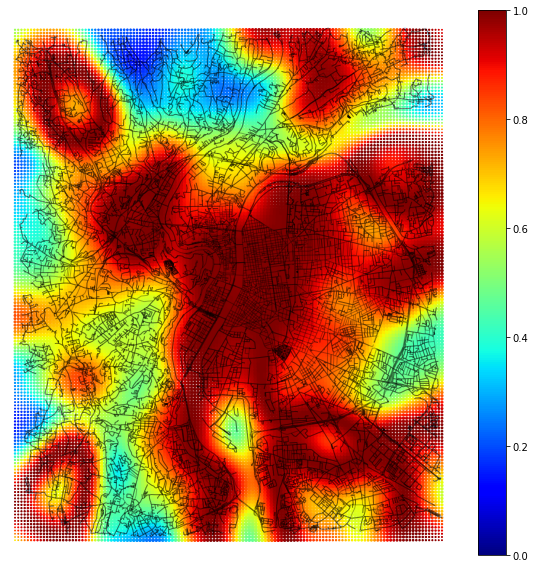

In [11]:
# Land use intensity serves as bubble size for land use mix indices
lum_bubble_size = df_indices.landuse_intensity.copy()
lum_bubble_size[ lum_bubble_size < 1e-5 ] = 0

fig, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
df_indices.plot("landusemix", markersize=50*lum_bubble_size, figsize=figsize, cmap="jet", legend=True, ax=ax, vmin=0, vmax=1)
fig.tight_layout()

### Alternatively, the output can be visualized separately
* Land use mix indices
* Land use intensity

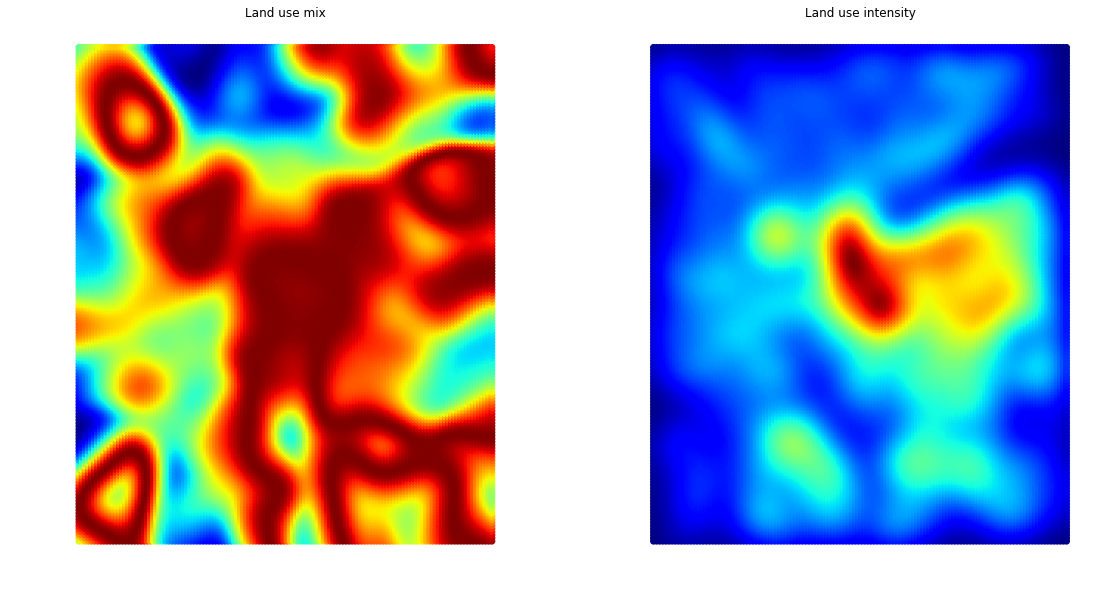

In [12]:
fig, axs = plt.subplots(1,2, figsize=(figsize[0] * 2, figsize[1]))
# Title
axs[0].set_title("Land use mix"); axs[1].set_title("Land use intensity")
axs[0].axis('off'); axs[1].axis('off')
# Plots
df_indices.plot("landusemix", figsize=figsize, cmap='jet', ax=axs[0])
df_indices.plot("landuse_intensity",figsize=figsize, cmap='jet', ax=axs[1])
fig.tight_layout(pad=0)